<a href="https://colab.research.google.com/github/Spookytober/Datascience/blob/main/AO_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)

In [ ]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    μ_nu = pm.Exponential('μ_nu', lam=1/30)
    μ_mu = pm.StudentT('μ_mu', nu=10, mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu=10)
    μ = pm.StudentT('μ', mu = μ_mu, nu = μ_nu, sigma = μ_sd,dims = "aa")
    σ = pm.HalfNormal('σ', sigma = 10, dims = "aa")
    v = pm.Exponential('v', lam=1/30)
    y = pm.StudentT('y',nu=v , mu = μ[aa_idx],sigma = σ[aa_idx],observed = cs_data.diff_TminusE)
    idata_cs_h = pm.sample()

Output()

Output()

In [ ]:
with pm.Model(coords=aa_coords) as cs_hN_model:
    μ_mu = pm.Normal('μ_mu1', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd1', sigma = 10)
    μ = pm.Normal('μ', mu = μ_mu, sigma = μ_sd, dims = "aa")
    σ = pm.HalfNormal('σ', sigma = 10, dims = "aa")
    y = pm.Normal('y', mu = μ[aa_idx],sigma = σ[aa_idx],observed = cs_data.diff_TminusE)
    idata_cs_hN = pm.sample()

Output()

Output()

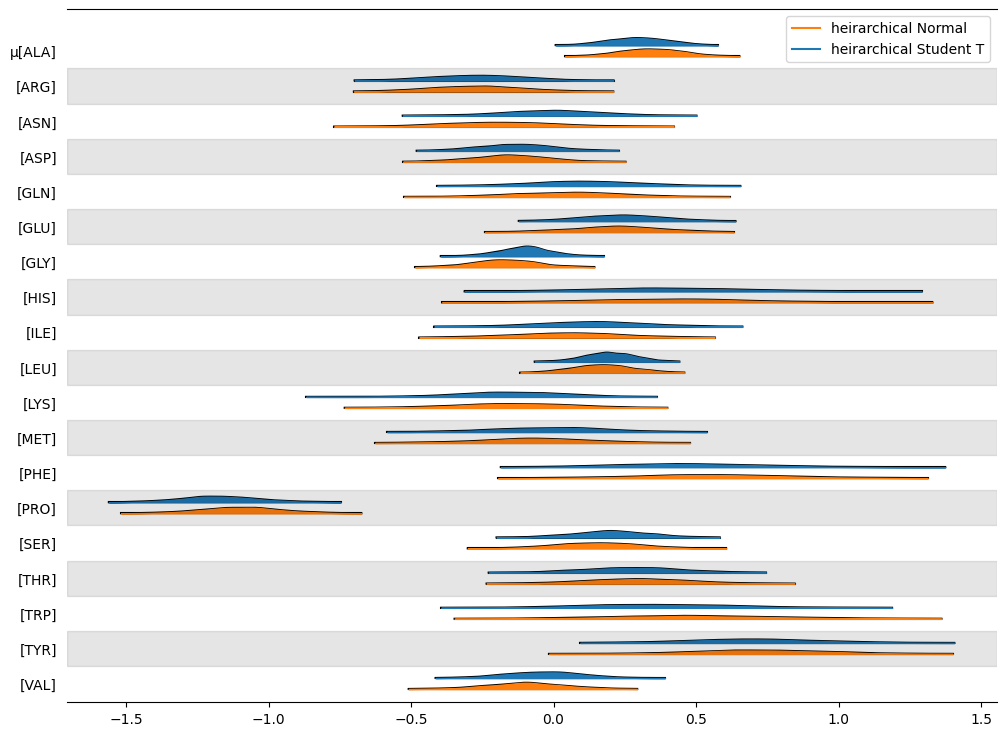

In [ ]:
axes = az.plot_forest([idata_cs_h,idata_cs_hN], kind="ridgeplot", model_names=['heirarchical Student T', 'heirarchical Normal'],var_names='μ',combined=True, figsize=(12, 9), hdi_prob=0.997)

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [ ]:
pm.sample_posterior_predictive(idata_cs_h, model = cs_h_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

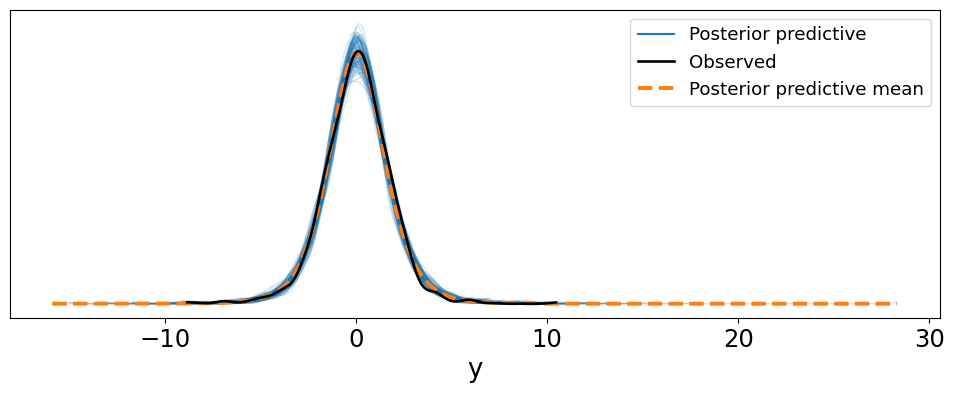

In [ ]:
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12,4))

In [ ]:
pm.sample_posterior_predictive(idata_cs_hN, model = cs_hN_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

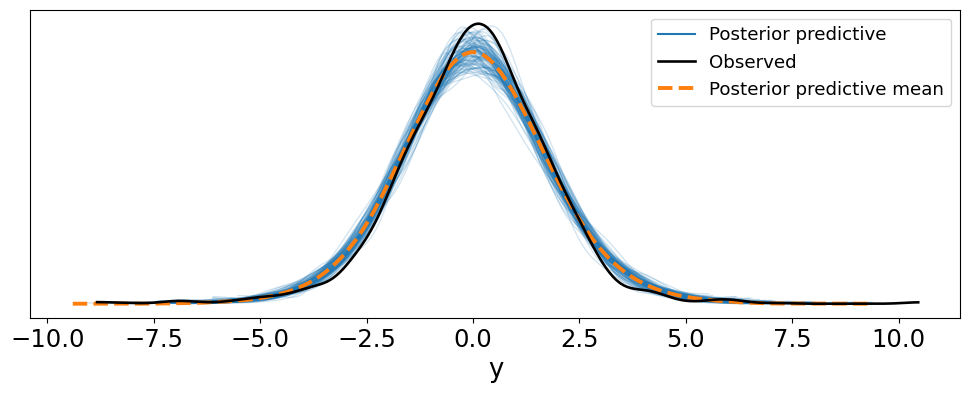

In [ ]:
az.plot_ppc(idata_cs_hN, num_pp_samples=100, figsize = (12,4))

Using Student-T and HalfStudent-T distributions as priors and hyperpriors created a likelihood that modeled the actual observed data much better than the model created by using Normal distributions as priors and hyperpriors. The top PPC, the Student-T one, shows a mean likelihood resembling the mean of the data, as opposed to the Normal PPC, which did not follow the observed data as well.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [42]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
pos_idx = sccr_data.position.cat.codes.values
pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

In [6]:
with pm.Model(coords = sccr_coords) as sccr_model_nh:
    μ = pm.Beta('μ_p', alpha = 2, beta = 20, dims = "pos")
    ν = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")
    θ = pm.Beta('θ', mu = μ[pos_idx], nu = ν[pos_idx])
    _ = pm.Binomial('gs',n = sccr_data.shots.values, p = θ, observed = sccr_data.goals.values)
    idata_sccr_nh = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [43]:
with pm.Model(coords = sccr_coords) as sccr_model:
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")
    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])
    _ = pm.Binomial('gs', n = sccr_data.shots.values, p = θ, observed = sccr_data.goals.values)
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

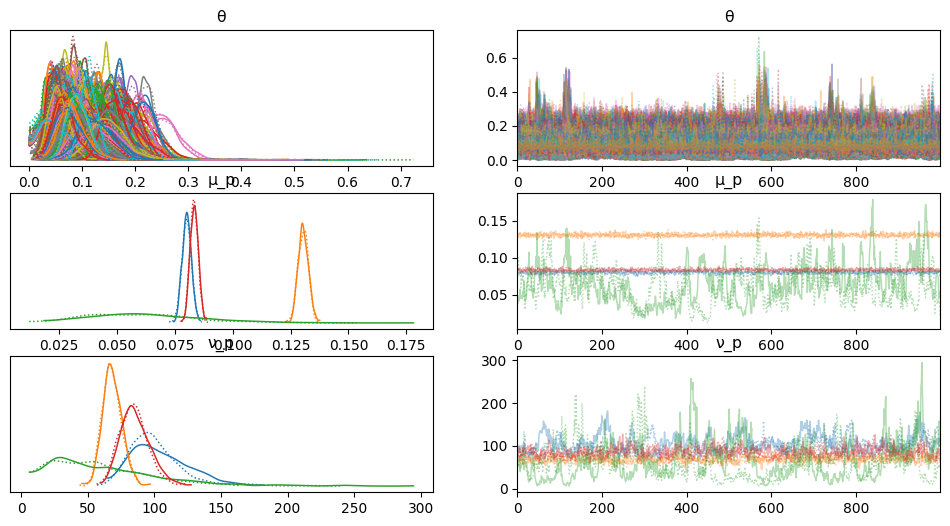

In [ ]:
az.plot_trace(idata_sccr_nh)

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

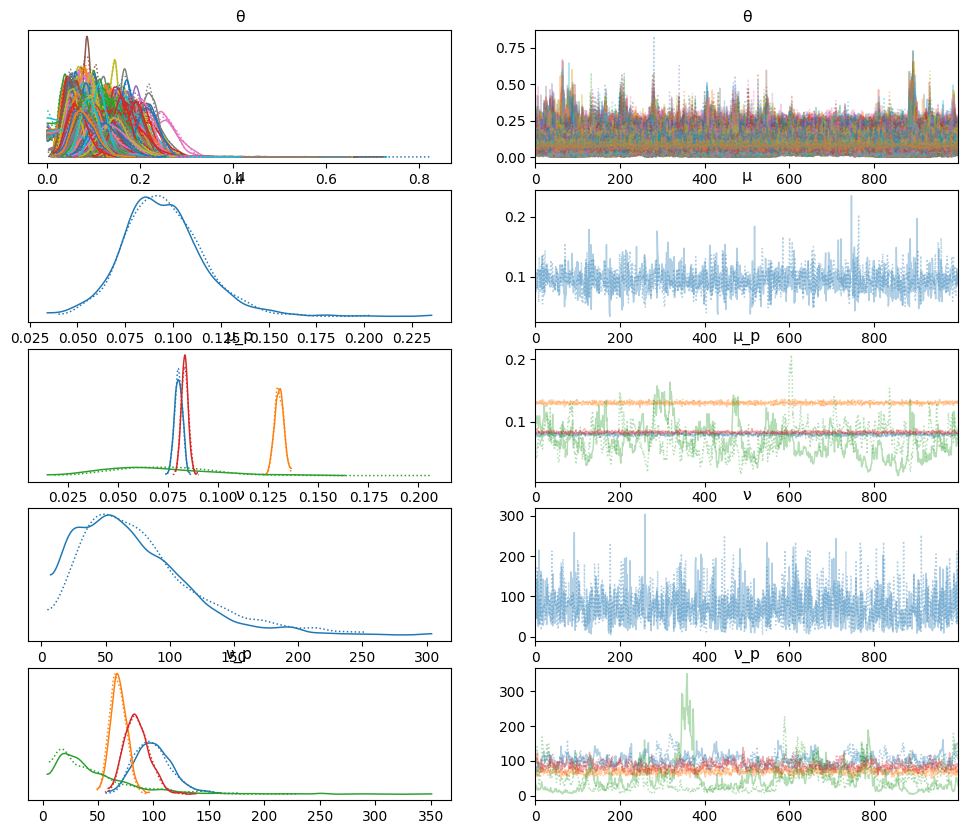

In [ ]:
az.plot_trace(idata_sccr)

I don't see a difference between the plot trace of the hierarchical and non-heirarchical models aside from the non-hierarchical model not having plots associated with hyperpriors.

In [ ]:
az.rhat(idata_sccr), az.rhat(idata_sccr_nh)

(<xarray.Dataset> Size: 43kB
 Dimensions:  (θ_dim_0: 2682, pos: 4)
 Coordinates:
   * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
   * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
 Data variables:
     θ        (θ_dim_0) float64 21kB 0.9998 1.001 1.005 1.001 ... 1.0 1.0 1.001
     μ        float64 8B 1.006
     μ_p      (pos) float64 32B 1.003 0.9997 1.064 1.001
     ν        float64 8B 1.006
     ν_p      (pos) float64 32B 1.018 0.9995 1.052 1.008,
 <xarray.Dataset> Size: 43kB
 Dimensions:  (θ_dim_0: 2682, pos: 4)
 Coordinates:
   * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
   * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
 Data variables:
     θ        (θ_dim_0) float64 21kB 1.0 0.9999 1.002 1.001 ... 1.003 1.001 1.004
     μ_p      (pos) float64 32B 1.002 0.9997 1.044 1.001
     ν_p      (pos) float64 32B 1.022 1.003 1.043 1.004)

The rhat values for the non heirarchical model's goalkeeper are slightly lower than the heirarchical model's. However, the rhat numbers for both were very similar

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

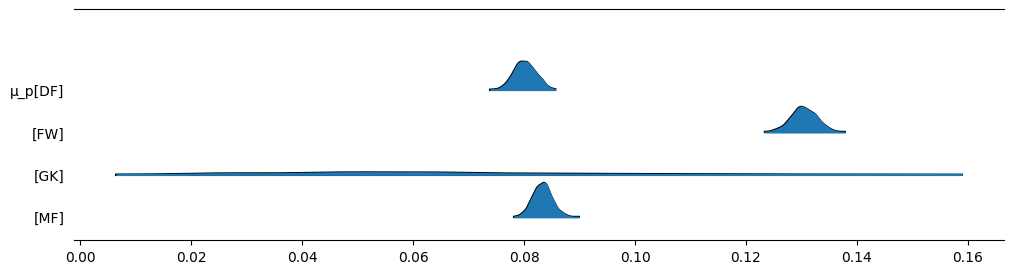

In [8]:
az.plot_forest(idata_sccr_nh, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

These posteriors look very similar to our hierarchical model. The goalkeeper column is spread even further thin in this one, but only by a small margin of 0.01.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [10]:
sccr_data #printing the sccr_data before I remove the GKs

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [32]:
#Max helped explain this part to me, because I had no idea how to do this.
idx = 0
rmIdx = 0
rmList = []
sccr_data_ngk = sccr_data

#creating a list of every single index that has the position GK.
for pos in sccr_data['position'].values:
  if pos == 'GK':
    rmList.append(idx)
  idx += 1

#removing this "removeList" from the original dataset
for gk in rmList:
  sccr_data_ngk = sccr_data_ngk.drop(sccr_data_ngk.index[gk-rmIdx])
  rmIdx += 1

sccr_data_ngk #a dataset with no goal keepers

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [36]:
pos_idx = sccr_data_ngk.position.cat.codes.values
pos_codes = sccr_data_ngk.position.cat.categories
sccr_coords = {"pos": pos_codes}
sccr_coords_ngk = sccr_coords
#deleting the goalkeeper category
sccr_coords_ngk['pos'] = sccr_coords_ngk['pos'].delete(2)
sccr_coords_ngk['pos']

Index(['DF', 'FW', 'MF'], dtype='object')

In [37]:
#going to turn pos_idx into a malleable list
idxlist = list(pos_idx)
#changing old values that were tied to GK into 2s because they are no longer tied to GK
for n in range(0,len(idxlist)):
  if idxlist[n] == 3:
    idxlist[n] -= 1

pos_idx = np.array(idxlist)

In [38]:
print(len(pos_idx))

2517


In [39]:
with pm.Model(coords = sccr_coords_ngk) as sccr_model_ngk:
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")
    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])
    _ = pm.Binomial('gs', n = sccr_data_ngk.shots.values, p = θ, observed = sccr_data_ngk.goals.values)
    idata_sccr_ngk = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


I apologize for the for loop abomination above.

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

(array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
        [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
        [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
        [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
        [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
       dtype=object),
 array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
        [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
        [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
        [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
        [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
       dtype=object))

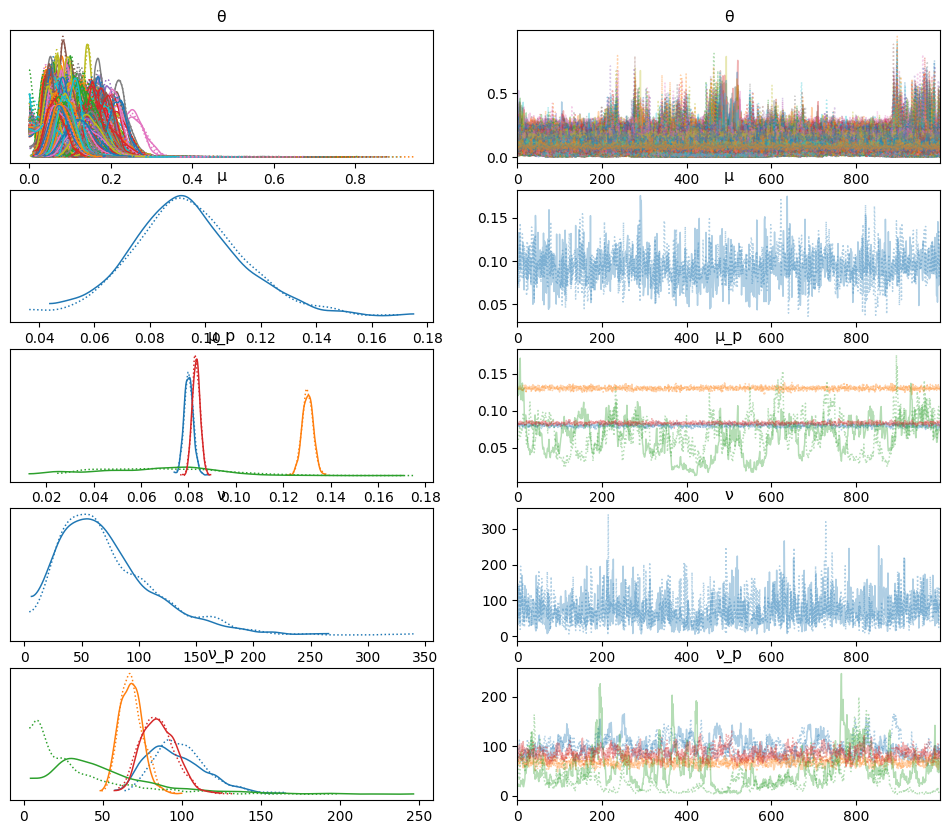

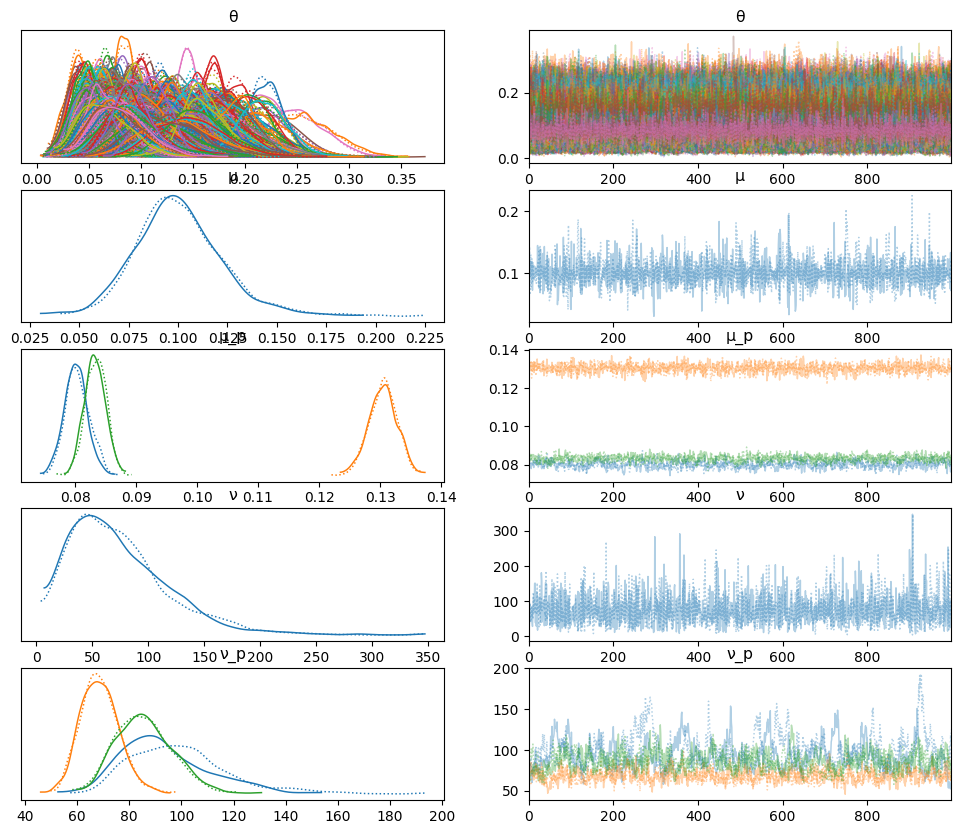

In [44]:
az.plot_trace(idata_sccr), az.plot_trace(idata_sccr_ngk)

In [45]:
az.rhat(idata_sccr), az.rhat(idata_sccr_ngk)

(<xarray.Dataset> Size: 43kB
 Dimensions:  (θ_dim_0: 2682, pos: 4)
 Coordinates:
   * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
   * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
 Data variables:
     θ        (θ_dim_0) float64 21kB 1.0 1.001 1.003 0.9993 ... 1.001 1.001 1.001
     μ        float64 8B 1.004
     μ_p      (pos) float64 32B 1.001 0.9994 1.027 1.0
     ν        float64 8B 1.007
     ν_p      (pos) float64 32B 1.031 1.002 1.095 1.007,
 <xarray.Dataset> Size: 40kB
 Dimensions:  (θ_dim_0: 2517, pos: 3)
 Coordinates:
   * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
   * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
 Data variables:
     θ        (θ_dim_0) float64 20kB 1.001 0.9994 1.002 ... 1.002 1.003 1.002
     μ        float64 8B 1.0
     μ_p      (pos) float64 24B 1.005 1.001 1.003
     ν        float64 8B 0.9999
     ν_p      (pos) float64 24B 1.036 0.9995 1.017)

I believe that the sans GK model was easier for pymc to process. The plot trace didn't throw a fit and have wierd, offset goalkeeper lines. Also, the rhat values for the model without the goalkeepers were generally more reasonable than the model with it.

By cutting out the GK category from our data set, some of our plot_traces came out rougher. However, we made it far easier for pymc to process them, and the time it took for the model to be created and plotted was 2 whole minutes less than with goalkeepers. Removing the goalkeepers made pymc able to move much quicker, while possibly losing a little bit of precision in its model.